# Analysis of injective flow results

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from pathlib import Path

from ciflows.flows import plFlowModel, TwoStageTraining
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

import logging
from pathlib import Path
import math
import lightning as pl
import normflows as nf
import numpy as np
import torch
import torch.nn as nn
from lightning.pytorch.callbacks import ModelCheckpoint
from normflows.flows.affine import GlowBlock
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

from ciflows.flows.glow import InjectiveGlowBlock, Squeeze
from ciflows.lightning import TwoStageTraining, plFlowModel

In [24]:
# reload the model from checkpoint
root = Path("/Users/adam2392/pytorch_data/ciflows/results/")

model_dir = root / "check_injflow_mnist_v2"
epoch = 999
step = 430000

model_fname = model_dir / f"epoch={epoch}-step={step}.ckpt"
model = plFlowModel.load_from_checkpoint(model_fname)

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'latent' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['latent'])`.
/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


In [25]:
latent = model.latent

print(latent)
samples = latent.sample(16)
print(samples.shape)
print(model.decoder.embed_dim)
self = model.decoder
print(self.patch_size * self.patch_size * self.in_channels)

DiagGaussian()
torch.Size([16, 64])
64
16


In [26]:
# Step 7: Evaluation
# model.eval()  # Set model to evaluation mode
# with torch.no_grad():
#     loss = evaluate_loss(model, val_loader, device) # Compute loss
#     avg_test_loss = loss.item()  # Accumulate test loss

# print(f'Test Loss: {avg_test_loss:.4f}')

# Step 8: Generate Samples
num_samples = 16
model.eval()
model = model.to(torch.device("cpu"))
with torch.no_grad():
    samples, _ = model.sample(num_samples)  # Generate samples
    samples = samples.view(-1, 1, 28, 28).cpu()  # Reshape for plotting

# Visualize generated samples

# Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)
save_image(grid_size, "generated_samples.png", normalize=True)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")

plt.show()

ValueError: not enough values to unpack (expected 3, got 2)

In [35]:
num_samples = 2

z, log_q = model.model.q0(num_samples)
for flow in model.model.flows:
    z, log_det = flow(z)
    log_q -= log_det
    print()
    print(flow, z.flatten()[0], log_q[0])
return z, log_q


GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): LeakyReLU(negative_slope=0.0)
              (2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
              (3): LeakyReLU(negative_slope=0.0)
              (4): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
        )
        (2): Merge()
      )
    )
    (1): Invertible1x1Conv()
    (2): ActNorm()
  )
) tensor(1.1539, grad_fn=<SelectBackward0>) tensor(-152.7195, grad_fn=<SelectBackward0>)

GlowBlock(
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): ConvNet2d(
            (net): Sequential(
              (0): Conv2d(1, 64, kernel

SyntaxError: 'return' outside function (1581086800.py, line 9)

## Sample build a model and demonstrate it

In [4]:
def get_model():
    n_hidden = 64
    n_mixing_layers = 2
    n_injective_layers = 3
    n_glow_blocks = 2
    use_lu = True
    gamma = 1e-2
    activation = "linear"

    input_shape = (1, 28, 28)
    n_channels = input_shape[0]

    n_chs = n_channels
    flows = []

    debug = True

    # add the initial mixing layers
    print("Beginning of mixing flows.")
    mixing_flows = []
    # Add flow layers starting from the latent representation
    for i in range(n_mixing_layers):
        # n_chs = C * 4^(L - i)
        n_chs = n_channels * 4 ** (n_mixing_layers - i)

        if debug:
            print(f"On layer {n_mixing_layers - i}, n_chs = {n_chs}")
        for j in range(n_glow_blocks):
            mixing_flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                )
            ]
        mixing_flows += [Squeeze()]

    # reverse the mixing flows to go from X -> V.
    mixing_flows = mixing_flows[::-1]
    i = 1
    for flow in mixing_flows:
        if hasattr(flow, "n_channels"):
            print(f"On layer {i}, n_chs = {flow.n_channels}")
            i += 1
    num_layers = i

    print("Beginning of injective flows.")
    n_chs = n_channels * 4 ** (n_mixing_layers - 0)
    debug = True
    # add injective blocks
    injective_flows = []
    for i in range(n_injective_layers):
        # Note: this is adding from V -> X
        n_chs = n_chs // 2
        injective_flows += [
            InjectiveGlowBlock(
                channels=n_chs,
                hidden_channels=n_hidden,
                activation=activation,
                scale=True,
                gamma=gamma,
            )
        ]

        if debug:
            print(f"On layer {i + num_layers}, n_chs = {n_chs}")
        for j in range(n_glow_blocks):
            injective_flows += [
                GlowBlock(
                    channels=n_chs,
                    hidden_channels=n_hidden,
                    use_lu=use_lu,
                    scale=True,
                )
            ]

    # Note: this is constructed as X -> V, so we need to reverse the flows
    # to adhere to the normflows convention of V -> X
    flows = mixing_flows
    flows.extend(injective_flows)
    flows = flows[::-1]

    print("n_channels: ", n_chs)
    q0 = nf.distributions.DiagGaussian((n_chs, 7, 7))

    model = nf.NormalizingFlow(q0=q0, flows=flows)

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    return model


def initialize_flow(model):
    """
    Initialize a full normalizing flow model
    """
    for name, param in model.named_parameters():
        if "weight" in name:
            # Layer-dependent initialization
            if "coupling" in name:
                nn.init.normal_(param, mean=0.0, std=0.01)
            else:
                nn.init.xavier_uniform_(param)
        elif "bias" in name:
            nn.init.constant_(param, 0.0)



In [6]:
# set seed
seed = 12345
np.random.seed(seed)
pl.seed_everything(seed, workers=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    accelerator = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    accelerator = "mps"
else:
    device = torch.device("cpu")
    accelerator = "cpu"

print(f"Using device: {device}")
print(f"Using accelerator: {accelerator}")

debug = False
fast_dev = False
max_epochs = 1000
if debug:
    accelerator = "cpu"
    fast_dev = True
    max_epochs = 1

batch_size = 128
n_steps_mse = 500
devices = 1
strategy = "auto"  # or ddp if distributed
num_workers = 4
gradient_clip_val = None  # 1.0
check_val_every_n_epoch = 5
monitor = "val_loss"

lr = 3e-4
lr_min = 1e-8
lr_scheduler = "cosine"

# whether or not to shuffle dataset
shuffle = True

# output filename for the results
root = "./data/"
model_name = "check_injflow_mnist_v2"
checkpoint_dir = Path("./results") / model_name
checkpoint_dir.mkdir(exist_ok=True, parents=True)

model_fname = f"{model_name}-model.pt"

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    save_top_k=5,
    monitor=monitor,
    every_n_epochs=check_val_every_n_epoch,
)


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logging.info(f"\n\n\tsaving to {model_fname} \n")

# Define the trainer
trainer = pl.Trainer(
    logger=False,
    max_epochs=max_epochs,
    devices=devices,
    strategy=strategy,
    callbacks=[checkpoint_callback, TwoStageTraining()],
    check_val_every_n_epoch=check_val_every_n_epoch,
    accelerator=accelerator,
    # fast_dev_run=fast_dev,
    # log_every_n_steps=1,
    # max_epochs=1,
    # limit_train_batches=1,
    # limit_val_batches=1,
)

# define the model
flow_model = get_model()
initialize_flow(flow_model)
model = plFlowModel(
    flow_model,
    lr=lr,
    lr_min=lr_min,
    lr_scheduler=lr_scheduler,
    n_steps_mse=n_steps_mse,
)

Seed set to 12345
INFO:root:

	saving to check_injflow_mnist_v2-model.pt 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Using device: mps
Using accelerator: mps
Beginning of mixing flows.
On layer 2, n_chs = 16
On layer 1, n_chs = 4
On layer 1, n_chs = 4
On layer 2, n_chs = 4
On layer 3, n_chs = 16
On layer 4, n_chs = 16
Beginning of injective flows.
inside initialization:  torch.Size([16, 8])
inside initialization:  Parameter containing:
tensor([[-0.1942,  0.0634,  0.3231,  0.0580,  0.2401, -0.0114,  0.5214,  0.1445],
        [ 0.1041, -0.0460,  0.2852,  0.0535,  0.1194, -0.4515, -0.0864, -0.4211],
        [-0.4225, -0.2292,  0.0601,  0.0507, -0.4036, -0.2738, -0.0351,  0.1540],
        [ 0.1345, -0.0907,  0.0060, -0.6056, -0.1964, -0.0372,  0.2407, -0.0949],
        [ 0.4798, -0.1775,  0.2529,  0.1438, -0.1702, -0.0647,  0.0084,  0.3470],
        [-0.0754,  0.4862,  0.3638, -0.1607, -0.1431,  0.0602, -0.2557,  0.1015],
        [-0.1375, -0.3893,  0.2542, -0.2078,  0.2968,  0.2019, -0.2934,  0.0822],
        [ 0.0060,  0.1169, -0.2229, -0.1864,  0.2985, -0.4137, -0.1001,  0.3628],
        [-0.3886, -0.

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1994.)
  LU, pivots, infos = torch._lu_with_info(
/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [12]:
# sample the data
num_samples = 16
samples, _ = model.sample(num_samples)
print(samples.shape)

torch.Size([16, 1, 28, 28])


torch.Size([3, 122, 122])


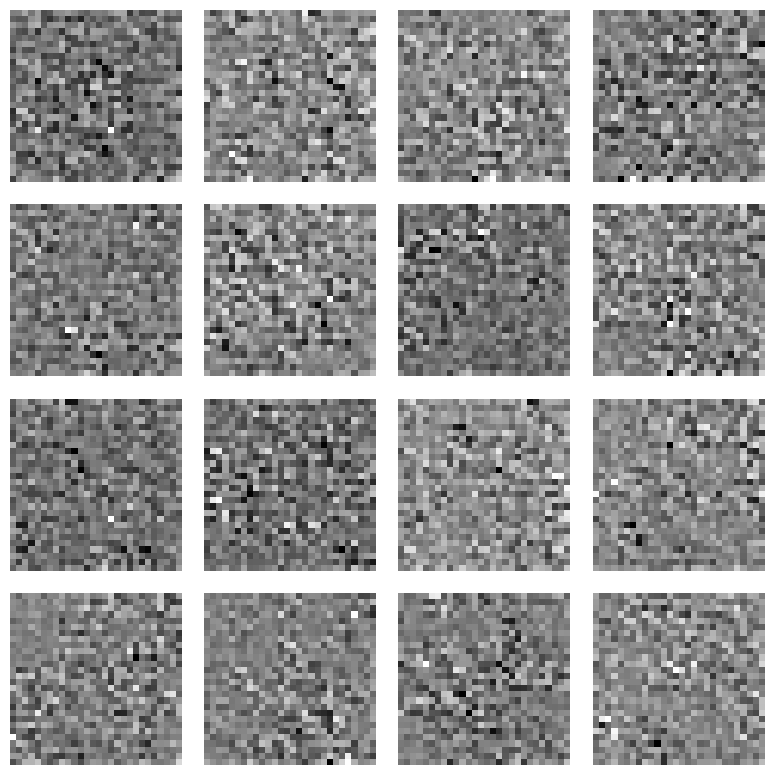

In [13]:
#  Visualize generated samples
grid_size = make_grid(samples, nrow=4, padding=2)

print(grid_size.shape)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(num_samples):
    ax = axes[i // 4, i % 4]
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")

In [ ]:
# inspect 